# anoGANs with noise


normal data : 0 ~ 4 숫자로 구성

anomalous data : 5 ~ 9 숫자로 구성

이미지 데이터는 64 by 64 크기는 -1 ~ 1

architecture는 DCGANs으로 구성


In [1]:
import tensorflow as tf
import numpy as np
import os
import sys
import time
import time 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

os.environ["CUDA_VISIBLE_DEVICES"]="0"


import pickle
import gzip

file_dir = 'anoGANs_MNIST_data/'

with gzip.open(file_dir + 'test_normal_data.pickle.gzip','rb') as f :
    test_normal_data = pickle.load(f)
    print('test_normal_data : ' ,test_normal_data.shape)

with gzip.open(file_dir + 'test_anomalous_data.pickle.gzip','rb') as f :
    test_anomalous_data = pickle.load(f)
    print('test_anomalous_data : ',test_anomalous_data.shape)
    
with gzip.open(file_dir + 'train_normal_data.pickle.gzip','rb') as f :
    train_normal_data = pickle.load(f)
    print('train_normal_data : ', train_normal_data.shape)
    
with gzip.open(file_dir + 'train_anomalous_data.pickle.gzip','rb') as f :
    train_anomalous_data = pickle.load(f)
    print('train_anomalous_data : ',train_anomalous_data.shape )

def idx_shuffle(x) : 
    l = x.shape[0]
    idx = np.arange(l)
    np.random.shuffle(idx)
    shuffled_x = np.empty(x.shape)

    for i in range(l):
        shuffled_x[idx[i]] = x[i]
    
    return shuffled_x

def mnist_4by4_save(samples,path):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)    
    gs.update(wspace=0.05, hspace=0.05) #이미지 사이간격 조절
  
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')    
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
   
        plt.imshow(sample.reshape(64, 64), cmap='Greys_r',clim=(0.0,1.0))
    plt.colorbar()
    plt.savefig(path, bbox_inches='tight')
    plt.close(fig)
   
    return None

def gan_loss_graph_save(G_loss,D_loss,path):
    x1 = range(len(G_loss))
    x2 = range(len(D_loss))
      
    y1 = G_loss
    y2 = D_loss
  
      
    plt.plot(x1,y1,label='G_loss') 
    plt.plot(x2,y2,label='D_loss') 
  
    plt.xlabel('weight per update')
    plt.ylabel('loss')             
    plt.legend(loc=4)              
    plt.grid(True)
    plt.tight_layout()
  
    plt.savefig(path)              

    return None


test_normal_data :  (5139, 64, 64, 1)
test_anomalous_data :  (4861, 64, 64, 1)
train_normal_data :  (28038, 64, 64, 1)
train_anomalous_data :  (26962, 64, 64, 1)


In [2]:


file_name = 'ex_anoGANs_5-case4'

if not os.path.isdir(file_name) :
    os.mkdir(file_name)
def simple_G(x,isTrain = True, reuse = False, name = 'G_out') : #input = (minibatch * w * h * ch)
    
    # out size = (in size + 2*padding - kenel)/strides + 1    
    w_init = tf.truncated_normal_initializer(mean= 0.0, stddev=0.02)
    b_init = tf.constant_initializer(0.0)


    with tf.variable_scope('G',reuse=reuse)  :
        
        #x = (-1, 1, 1, 100)

        conv1 = tf.layers.conv2d_transpose(x,1024,[4,4], strides=(1,1),padding = 'valid',
                kernel_initializer=w_init, bias_initializer=b_init) 
        r1 = tf.nn.elu(tf.layers.batch_normalization(conv1,training=isTrain))#1024*4*4
        
        conv2 = tf.layers.conv2d_transpose(r1,512,[5,5], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#512*8*8
                
        conv3 = tf.layers.conv2d_transpose(r2,256,[5,5], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain))#256*16*16

        conv4 = tf.layers.conv2d_transpose(r3,128,[5,5], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r4 = tf.nn.elu(tf.layers.batch_normalization(conv4,training=isTrain))#128*32*32

        conv5 = tf.layers.conv2d_transpose(r4,1,[5,5], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init) #1*64*64
        
    r5= tf.nn.tanh(conv5,name=name)#1*64*64
  
    return r5

def residual_loss_G(x,isTrain = False, reuse = True, name = 'residual_loss_out') : #input = (minibatch * w * h * ch)
    
    # out size = (in size + 2*padding - kenel)/strides + 1    


    with tf.variable_scope('G',reuse=reuse) as scope :
        scope.reuse_variables()
        #x = (-1, 1, 1, 100)


        conv1 = tf.layers.conv2d_transpose(x,1024,[4,4], strides=(1,1),padding = 'valid')
        r1 = tf.nn.elu(tf.layers.batch_normalization(conv1,training=isTrain))#1024*4*4
        
        conv2 = tf.layers.conv2d_transpose(r1,512,[5,5], strides=(2,2),padding = 'same')
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#512*8*8
                
        conv3 = tf.layers.conv2d_transpose(r2,256,[5,5], strides=(2,2),padding = 'same')
        r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain))#256*16*16

        conv4 = tf.layers.conv2d_transpose(r3,128,[5,5], strides=(2,2),padding = 'same')
        r4 = tf.nn.elu(tf.layers.batch_normalization(conv4,training=isTrain))#128*32*32

        conv5 = tf.layers.conv2d_transpose(r4,1,[5,5], strides=(2,2),padding = 'same')
        
    r5= tf.nn.tanh(conv5,name=name)#1*64*64
    return r5

def simple_D(x,isTrain=True,reuse = False) :
    
    w_init = tf.truncated_normal_initializer(mean= 0.0, stddev=0.02)
    b_init = tf.constant_initializer(0.0)
    with tf.variable_scope('D', reuse=reuse) :
        
        #x = (-1,64,64,1)
        # out size = (in size + 2*padding - kenel)/strides + 1   

        conv1 = tf.layers.conv2d(x,128,[5,5], strides=(2,2),padding = 'same',
                                kernel_initializer=w_init, bias_initializer=b_init) 
        r1 = tf.nn.elu(conv1)#128*32*32

   
        conv2 = tf.layers.conv2d(r1,256,[5,5], strides=(2,2),padding = 'same',
                                kernel_initializer=w_init, bias_initializer=b_init)
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#256*16*16

  
        conv3 = tf.layers.conv2d(r2,512,[5,5], strides=(2,2),padding = 'same',
                                kernel_initializer=w_init, bias_initializer=b_init)
        r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain))#512*8*8

 
        conv4 = tf.layers.conv2d(r3,1024,[5,5], strides=(2,2),padding = 'same',
                                kernel_initializer=w_init, bias_initializer=b_init)
        r4 = tf.nn.elu(tf.layers.batch_normalization(conv4,training=isTrain))#1024*4*4


        conv5 = tf.layers.conv2d(r4,1,[4,4], strides=(1,1),padding = 'valid',
                                kernel_initializer=w_init, bias_initializer=b_init)
      
    r5 = tf.nn.sigmoid(conv5)#1*1*1

    return r5

def feature_extractor_D(x,isTrain=False,reuse = True, name='feature_out') :
    
    with tf.variable_scope('D', reuse=reuse) as scope :
        scope.reuse_variables()
        #x = (-1,28,28,1)

        conv1 = tf.layers.conv2d(x,128,[5,5], strides=(2,2),padding = 'same') 
        r1 = tf.nn.elu(conv1)#128*32*32

   
        conv2 = tf.layers.conv2d(r1,256,[5,5], strides=(2,2),padding = 'same')
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#256*16*16

  
        conv3 = tf.layers.conv2d(r2,512,[5,5], strides=(2,2),padding = 'same')
    r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain),name=name)#512*8*8

 
        #conv4 = tf.layers.conv2d(r3,1024,[5,5], strides=(2,2),padding = 'same')
        #r4 = tf.nn.elu(tf.layers.batch_normalization(conv4,training=isTrain))#1024*4*4


        #conv5 = tf.layers.conv2d(r4,1,[4,4], strides=(1,1),padding = 'valid')
      
        #r5 = tf.nn.sigmoid(conv5)#1*1*1



    return r3



In [3]:
lr = 0.001
train_epoch = 100
batch_size = 100
z_size = 5


z = tf.placeholder(tf.float32,shape=(None,1,1,z_size),name = 'z')    
u = tf.placeholder(tf.float32, shape = (None, 64,64,1),name='u')

noise = tf.placeholder(tf.float32, shape = (None, 64,64,1),name='noise')

test_u = tf.placeholder(tf.float32, shape = (None, 64,64,1),name='test_u')
latent_z = tf.placeholder(tf.float32,shape=(None,1,1,z_size),name = 'latent_z')    

isTrain = tf.placeholder(dtype=tf.bool,name='isTrain') 

soft_one = tf.placeholder(tf.float32, shape = (None, 1,1,1),name='soft_one') # 0.9~1.0
soft_zero = tf.placeholder(tf.float32, shape = (None, 1,1,1),name='soft_zero') # 0.0~0.1

ramda = tf.placeholder(tf.float32,name='ramda') # 0.0~0.1

G_z = simple_G(z,name='G_z')

D_real = simple_D(u +noise, isTrain)
D_fake = simple_D(G_z+noise ,isTrain,reuse=True)

query_z =  residual_loss_G(latent_z, reuse = True,name ='query_z')


discrimination_from_query_z= simple_D(query_z,isTrain=False,reuse=True)

feature_u = feature_extractor_D(test_u, reuse = True, name ='feature_y')
feature_z = feature_extractor_D(query_z, reuse = True, name ='feature_z')


D_real_loss = tf.reduce_mean(-(soft_one*tf.log(D_real + 1e-8) + (1-soft_one)*tf.log(1- D_real + 1e-8)),name = 'D_real_loss')
D_fake_loss = tf.reduce_mean(-(soft_zero*tf.log(D_fake + 1e-8) + (1-soft_zero)*tf.log(1 - D_fake + 1e-8)),name = 'D_fake_loss')


D_loss =  tf.add(D_real_loss,D_fake_loss,name='D_loss')
G_loss =  tf.reduce_mean(-tf.log(D_fake + 1e-8),name='G_loss')

residual_loss = tf.reduce_mean(tf.abs(query_z - test_u),axis = (1,2,3), name = 'residual_loss')
feature_loss = tf.reduce_mean(tf.abs(feature_u-feature_z),axis = (1,2,3),name = 'feature_loss')
discrimination_loss = tf.reduce_mean(-tf.log(discrimination_from_query_z+ 1e-8),axis = (1),name = 'discrimination_loss')

mapping_loss = tf.add((1-ramda)*residual_loss, ramda*feature_loss,name = 'mapping_loss') 

T_vars = tf.trainable_variables()
D_vars = [var for var in T_vars if var.name.startswith('D')]
G_vars = [var for var in T_vars if var.name.startswith('G')]
    # When using the batchnormalization layers,
    # it is necessary to manually add the update operations
    # because the moving averages are not included in the graph

with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)) :        
    D_optim = tf.train.AdamOptimizer(lr,beta1=0.5).minimize(D_loss, var_list=D_vars, name='D_optim') 
    G_optim = tf.train.AdamOptimizer(lr,beta1=0.5).minimize(G_loss, var_list=G_vars, name='G_optim')
    
grad_z = tf.gradients(mapping_loss, latent_z, name ='grad_z')
print(grad_z)

[<tf.Tensor 'grad_z/G_1/conv2d_transpose/conv2d_transpose_grad/Conv2D:0' shape=(?, 1, 1, 5) dtype=float32>]


# train DCGANs

D_e : 2.764129, D_real_e : 0.877074, D_fake_e : 0.830628, G_e : 2.767340
D_e : 2.333988, D_real_e : 0.758023, D_fake_e : 0.715685, G_e : 2.426202
D_e : 2.038423, D_real_e : 0.597571, D_fake_e : 0.554157, G_e : 2.218822
D_e : 1.795826, D_real_e : 0.433315, D_fake_e : 0.392123, G_e : 1.966463
D_e : 1.620609, D_real_e : 0.387232, D_fake_e : 0.357289, G_e : 1.810094
D_e : 1.473157, D_real_e : 0.303355, D_fake_e : 0.285090, G_e : 1.613379
D_e : 1.363810, D_real_e : 0.306870, D_fake_e : 0.291514, G_e : 1.481755
D_e : 1.269719, D_real_e : 0.264761, D_fake_e : 0.252227, G_e : 1.349028
D_e : 1.201635, D_real_e : 0.299834, D_fake_e : 0.289051, G_e : 1.274412
D_e : 1.154726, D_real_e : 0.355323, D_fake_e : 0.330308, G_e : 1.244741
D_e : 1.094116, D_real_e : 0.213717, D_fake_e : 0.213688, G_e : 1.144907
D_e : 1.070991, D_real_e : 0.411235, D_fake_e : 0.382261, G_e : 1.152255
D_e : 1.024578, D_real_e : 0.211272, D_fake_e : 0.209939, G_e : 1.072473
D_e : 0.995747, D_real_e : 0.296964, D_fake_e : 0.2

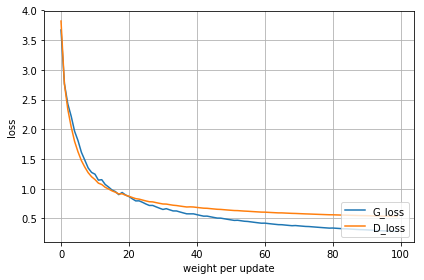

In [4]:
with tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))) as sess :
    sess.run(tf.global_variables_initializer())

    np.random.seed(int(time.time()))

    test_z = np.random.normal(0,1,size=(16,1,1,z_size))

    
    log_txt = open(file_name +'/log.txt','w')

    hist_G = []
    hist_D = []
    G_error = []
    D_error = []
    D_fake_error = []
    D_real_error = []
    
    start = time.time()
    for epoch in range(train_epoch) :
        
        np.random.seed(int(time.time()))
        train_normal_data = idx_shuffle(train_normal_data) 
        
        for iteration in range(train_normal_data.shape[0] // batch_size) : 
        
            train_images = train_normal_data[iteration*batch_size : (iteration+1)*batch_size]      
            u_ = np.reshape(train_images,(-1,64,64,1)) 
            z_ = np.random.normal(0,0.1,size=(batch_size,1,1,z_size))
              
            z_ = np.maximum(-1, z_)
            z_ = np.minimum(1,z_)
            
            noise_ = np.random.normal(0,0.1,size=(batch_size,64,64,1))
            zeros_ = np.zeros([batch_size,64,64,1])
            soft_one_ = np.random.uniform(0.9,1.0,(batch_size,1,1,1))
            soft_zero_ = np.random.uniform(0.0,0.1,(batch_size,1,1,1))
        
      
            _ , D_e,D_real_e,D_fake_e = sess.run([D_optim, D_loss,D_real_loss,D_fake_loss], {u : u_, z : z_, isTrain : True,
                                                                                         noise : noise_, soft_one : soft_one_, soft_zero : soft_zero_})
            D_error.append(D_e)
            D_real_error.append(D_real_e)
            D_fake_error.append(D_fake_e)

            #    train_images,train_labels = mnist.train.next_batch(100)    
            #    u_ = np.reshape(train_images,(-1,64,64,1)) 
            #    z_ = np.random.normal(0,1,size=(100,1,1,100))
   
            _ , G_e = sess.run([G_optim, G_loss], {u : u_, z : z_,noise : zeros_, isTrain : True}) 
            G_error.append(G_e)
        


        hist_D.append(np.mean(D_error)) 
        hist_G.append(np.mean(G_error))

        print('D_e : %.6f, D_real_e : %.6f, D_fake_e : %.6f, G_e : %.6f'%(np.mean(D_error), np.mean(D_real_error),
            np.mean(D_fake_error), np.mean(G_error)))
        log_txt.write('D_e : %.6f, D_real_e : %.6f, D_fake_e : %.6f, G_e : %.6f\n'%(np.mean(D_error),
            np.mean(D_real_error), np.mean(D_fake_error), np.mean(G_error)))
      
        r = sess.run([G_z],feed_dict={z : test_z, isTrain : False})        
        mnist_4by4_save(np.reshape(r,(-1,64,64,1)),file_name + '/result_{}.png'.format(str(epoch).zfill(3)))

        np.random.seed(int(time.time()))

        G_errer = []
        D_errer = []
        D_fake_error = []
        D_real_error = []


    log_txt.close()
    gan_loss_graph_save(G_loss = hist_G,D_loss=hist_D,path = file_name + '/loss_graph.png')   
    saver = tf.train.Saver()
    saver.save(sess,file_name + '/para.cktp')

    end = time.time()-start

    print("total time : ",end)

# Detect anomalous data

## load networks

In [5]:


if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
u = sess.graph.get_tensor_by_name("u:0")

noise = sess.graph.get_tensor_by_name("noise:0")

test_u = sess.graph.get_tensor_by_name("test_u:0")
latent_z = sess.graph.get_tensor_by_name("latent_z:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

soft_one =sess.graph.get_tensor_by_name("soft_one:0") # 0.9~1.0
soft_zero = sess.graph.get_tensor_by_name("soft_zero:0") # 0.0~0.1

ramda = sess.graph.get_tensor_by_name("ramda:0")

G_z = sess.graph.get_tensor_by_name("G_z:0")
query_z = sess.graph.get_tensor_by_name("query_z:0")


feature_u = sess.graph.get_tensor_by_name('feature_y:0')
feature_z = sess.graph.get_tensor_by_name('feature_z:0')

D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")

residual_loss = sess.graph.get_tensor_by_name("residual_loss:0")
feature_loss = sess.graph.get_tensor_by_name("feature_loss:0")
discrimination_loss = sess.graph.get_tensor_by_name("discrimination_loss:0")
mapping_loss = sess.graph.get_tensor_by_name("mapping_loss:0")

D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")

grad_z =  sess.graph.get_tensor_by_name("grad_z/G_1/conv2d_transpose/conv2d_transpose_grad/Conv2D:0")




INFO:tensorflow:Restoring parameters from ex_anoGANs_5-case4/para.cktp


## detect

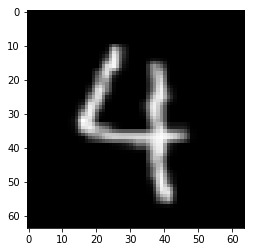

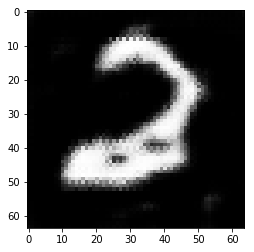

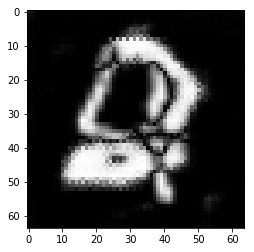

[array([[[[-0.18333316, -0.97889394, -3.59842801,  0.83494639,  2.0546031 ]]]], dtype=float32)]
[ 1.47530377] [ 11.86862946] [ 0.32048982]
[ 1.47530389] [ 11.86863041] [ 0.32048982] [[[ 0.04890658]]]
[ 0.63771743] [ 5.32112265] [ 0.11733903] [[[ 0.04577593]]]
[ 0.63775009] [ 5.32190037] [ 0.11728896] [[[ 0.04577605]]]
[ 0.63769639] [ 5.32070923] [ 0.11736158] [[[ 0.04581705]]]
[ 0.63764203] [ 5.31941319] [ 0.11744518] [[[ 0.04582946]]]
[ 0.63775992] [ 5.32202959] [ 0.11728552] [[[ 0.04580532]]]
[ 0.63765121] [ 5.31976795] [ 0.11741598] [[[ 0.04583639]]]
[ 0.63764954] [ 5.31976891] [ 0.11741409] [[[ 0.04589405]]]
[ 0.63778508] [ 5.32235861] [ 0.11727691] [[[ 0.04579015]]]


In [ ]:
####   여기는 아직 못함
test_batch = 1
ramda_ = 0.1
z_size = 5
np.random.seed(1)
latent_z_ = np.random.normal(0,0.1,size=(test_batch,1,1,z_size))
####


im =  test_normal_data[11]      
plt.imshow(np.reshape(im,(64, 64)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([query_z],{latent_z : latent_z_}) 
plt.imshow(np.reshape(im_fake,(64, 64)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(64, 64)) - np.reshape(im,(64, 64)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  
print(sess.run([grad_z],{test_u : np.reshape(im,(-1,64, 64,1)), latent_z : latent_z_, ramda : ramda_ }))

############################################


#latent_z_ = np.random.normal(0,1,size=(test_batch,1,1,z_size))
map_loss, fea_loss, res_loss = sess.run([mapping_loss, feature_loss,residual_loss], 
                                        {test_u : np.reshape(im,(1,64, 64,1)), latent_z : latent_z_, ramda : ramda_ })
adam_m = np.zeros((test_batch,1,1,z_size))
adam_v = np.zeros((test_batch,1,1,z_size))
beta1 = 0.5
beta2 = 0.999
lr = 0.001
beta1_t = beta1
beta2_t = beta2

print(map_loss, fea_loss, res_loss)

for i in range(1000) :
     
    grad,map_loss, fea_loss, res_loss,dis_loss = sess.run([grad_z,mapping_loss, feature_loss,residual_loss,discrimination_loss],
                                                 {test_u : np.reshape(im,(-1,64, 64,1)), latent_z : latent_z_, ramda : ramda_ })
    
    lr_t = lr*np.sqrt(1-beta2_t)/(1-beta1_t)
    adam_m = beta1*adam_m + (1-beta1)*grad
    adam_v = beta2*adam_v + (1-beta2)*grad*grad
    latent_z_ = latent_z_ - lr*adam_m/(np.sqrt(adam_v)+1e-8)
    beta1_t = beta1_t*beta1
    beta2_t = beta2_t*beta2
    
    #latent_z_ = np.maximum(-1, latent_z_)
    #atent_z_ = np.minimum(1,latent_z_)
    
    
    if  i % 100 == 0 : 
        print(map_loss, fea_loss, res_loss, dis_loss)
        
###########################################        
plt.imshow(np.reshape(im,(64, 64)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([query_z],{latent_z : latent_z_}) 
plt.imshow(np.reshape(im_fake,(64,64)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(64,64)) - np.reshape(im,(64,64)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

map_loss, fea_loss, res_loss = sess.run([mapping_loss, feature_loss,residual_loss], 
                                        {test_u : np.reshape(im,(-1,64,64,1)), latent_z : latent_z_, ramda : ramda_ })


print(map_loss, fea_loss, res_loss, np.mean(latent_z_**2 ))
latent_z_

0 : [ 1.01369643] [ 8.82522583] [ 0.1457487] 0.286353598794

1 : [ 0.76308692] [ 6.78434467] [ 0.09405826] 1.03380027707

2: [ 1.89532161] [ 16.23123932] [ 0.30244178] 0.177868586814

6 : [ 1.67973995] [ 14.42055035] [ 0.26409432] 0.326114747332

7: [ 1.03701472] [ 9.18771935] [ 0.13138092] 0.47285114037

9: [ 1.6167779] [ 14.07862568] [ 0.23212823] 0.75386729395

In [ ]:
latent_z_

In [ ]:
####
test_batch = 3
np.random.seed(1)
latent_z_ = np.random.normal(0,1,size=(test_batch,1,1,z_size))
####

im = test_anomalous_data[110:113]      


############################################

ramda_ = 0.1
z_size = 100
#latent_z_ = np.random.normal(0,1,size=(test_batch,1,1,z_size))
map_loss, fea_loss, res_loss = sess.run([mapping_loss, feature_loss,residual_loss], 
                                        {test_u : np.reshape(im,(-1,64, 64,1)), latent_z : latent_z_, ramda : ramda_ })
adam_m = np.zeros((test_batch,1,1,z_size))
adam_v = np.zeros((test_batch,1,1,z_size))
beta1 = 0.5
beta2 = 0.999
lr = 0.001
beta1_t = beta1
beta2_t = beta2

print(map_loss, fea_loss, res_loss)

for i in range(1000) :
     
    grad,map_loss, fea_loss, res_loss = sess.run([grad_z,mapping_loss, feature_loss,residual_loss],
                                                 {test_u : np.reshape(im,(-1,64, 64,1)), latent_z : latent_z_, ramda : ramda_ })
    
    lr_t = lr*np.sqrt(1-beta2_t)/(1-beta1_t)
    adam_m = beta1*adam_m + (1-beta1)*grad
    adam_v = beta2*adam_v + (1-beta2)*grad*grad
    latent_z_ = latent_z_ - lr*adam_m/(np.sqrt(adam_v)+1e-8)
    beta1_t = beta1_t*beta1
    beta2_t = beta2_t*beta2
    
    if  i % 100 == 0 : 
        print(map_loss, fea_loss, res_loss)
        
###########################################        

    

map_loss, fea_loss, res_loss = sess.run([mapping_loss, feature_loss,residual_loss], 
                                        {test_u : np.reshape(im,(-1,64, 64,1)), latent_z : latent_z_, ramda : ramda_ })

print('ddd')
print(map_loss, fea_loss, res_loss)                   

In [ ]:
grad.shape

In [ ]:
map_loss

In [ ]:
plt.imshow(np.reshape(im[2],(28,28)), cmap='Greys_r')
plt.show()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [ ]:
im_fake = sess.run([query_z],{latent_z : latent_z_[2].reshape(1,1,1,100)}) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

In [ ]:
latent_z_[0].reshape(1,1,1,100).shape